In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import shap
from flask import Flask, request, render_template, jsonify

In [2]:
# Load your dataset
data = pd.read_csv("C:/Users/aadhi/OneDrive/Desktop/Mini project/weatherHistory.csv")

In [3]:
# Check for missing values
missing_values = data.isnull().sum()
print(missing_values)

Formatted Date                0
Summary                       0
Precip Type                 517
Temperature (C)               0
Apparent Temperature (C)      0
Humidity                      0
Wind Speed (km/h)             0
Wind Bearing (degrees)        0
Visibility (km)               0
Loud Cover                    0
Pressure (millibars)          0
Daily Summary                 0
dtype: int64


In [4]:
print(data.head())

                  Formatted Date        Summary Precip Type  Temperature (C)  \
0  2006-04-01 00:00:00.000 +0200  Partly Cloudy        rain         9.472222   
1  2006-04-01 01:00:00.000 +0200  Partly Cloudy        rain         9.355556   
2  2006-04-01 02:00:00.000 +0200  Mostly Cloudy        rain         9.377778   
3  2006-04-01 03:00:00.000 +0200  Partly Cloudy        rain         8.288889   
4  2006-04-01 04:00:00.000 +0200  Mostly Cloudy        rain         8.755556   

   Apparent Temperature (C)  Humidity  Wind Speed (km/h)  \
0                  7.388889      0.89            14.1197   
1                  7.227778      0.86            14.2646   
2                  9.377778      0.89             3.9284   
3                  5.944444      0.83            14.1036   
4                  6.977778      0.83            11.0446   

   Wind Bearing (degrees)  Visibility (km)  Loud Cover  Pressure (millibars)  \
0                   251.0          15.8263         0.0               1015.13  

In [5]:
# Display basic information about the DataFrame
print(data.info())

# Display summary statistics
print(data.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB
None
       Temperature (C)  Apparent Temperature (C)      Humidity  

In [6]:
# Drop rows with missing values
df = data.dropna()

# Fill missing values with a specific value
# df = df.fillna(0)


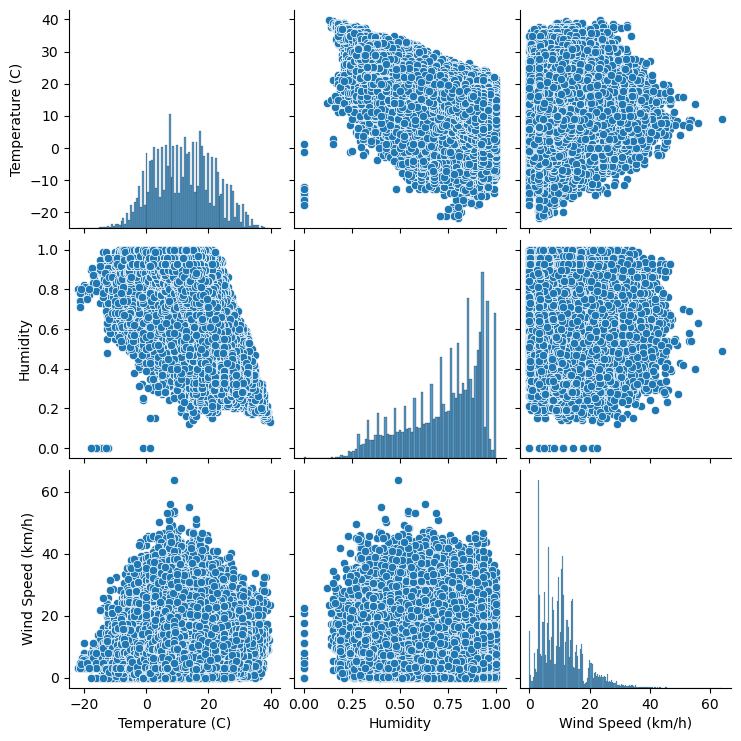

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Pairplot for selected columns
sns.pairplot(df[['Temperature (C)', 'Humidity', 'Wind Speed (km/h)']])
plt.show()

In [8]:
# Feature Engineering
# For simplicity, let's assume 'Heavy Rain' is the label for heavy precipitation events
df['HeavyRain'] = (df['Precip Type'] == 'rain') > 2.0



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
# Select relevant features
features = ['Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover', 'Pressure (millibars)']

In [10]:
# Split the data into features (X) and target variable (y)
X = df[features]
y = df['HeavyRain']

In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [13]:
# SHAP values for explainability
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)

In [14]:
# Flask web application
app = Flask(__name__)

In [15]:
@app.route('/')
def home():
    return render_template('index.html')  # Render a HTML template for user input

@app.route('/result', methods=['POST'])
def predict():
    input_data = request.form.to_dict()
    
    # Preprocess input data if needed
    # ...
    
    # Make prediction using the trained classifier
    prediction = clf.predict(input_data)
    
    # Calculate SHAP values for the input data
    shap_values_single = explainer.shap_values(input_data)
    
    # Return prediction and SHAP values as JSON response
    return jsonify({'prediction': prediction.tolist(), 'shap_values': shap_values_single.tolist()})
    # Receive input data from the form
    temperature = request.form['Temperature (C)']
    apparent_temperature = request.form['Apparent Temperature (C)']
    # Add similar code for other input fields

    # Convert input data to the format expected by the model
    input_data = pd.DataFrame({
        'Temperature (C)': [float(temperature)],
        'Apparent Temperature (C)': [float(apparent_temperature)],
        # Add similar code for other input fields
    })

    # Make prediction using the trained model
    prediction = clf.predict(input_data)
    
    # Calculate SHAP values for the input data
    shap_values_single = explainer.shap_values(input_data)

    # Render the result page with prediction and SHAP values
    return render_template('result.html', prediction=prediction, explanation=shap_values_single)